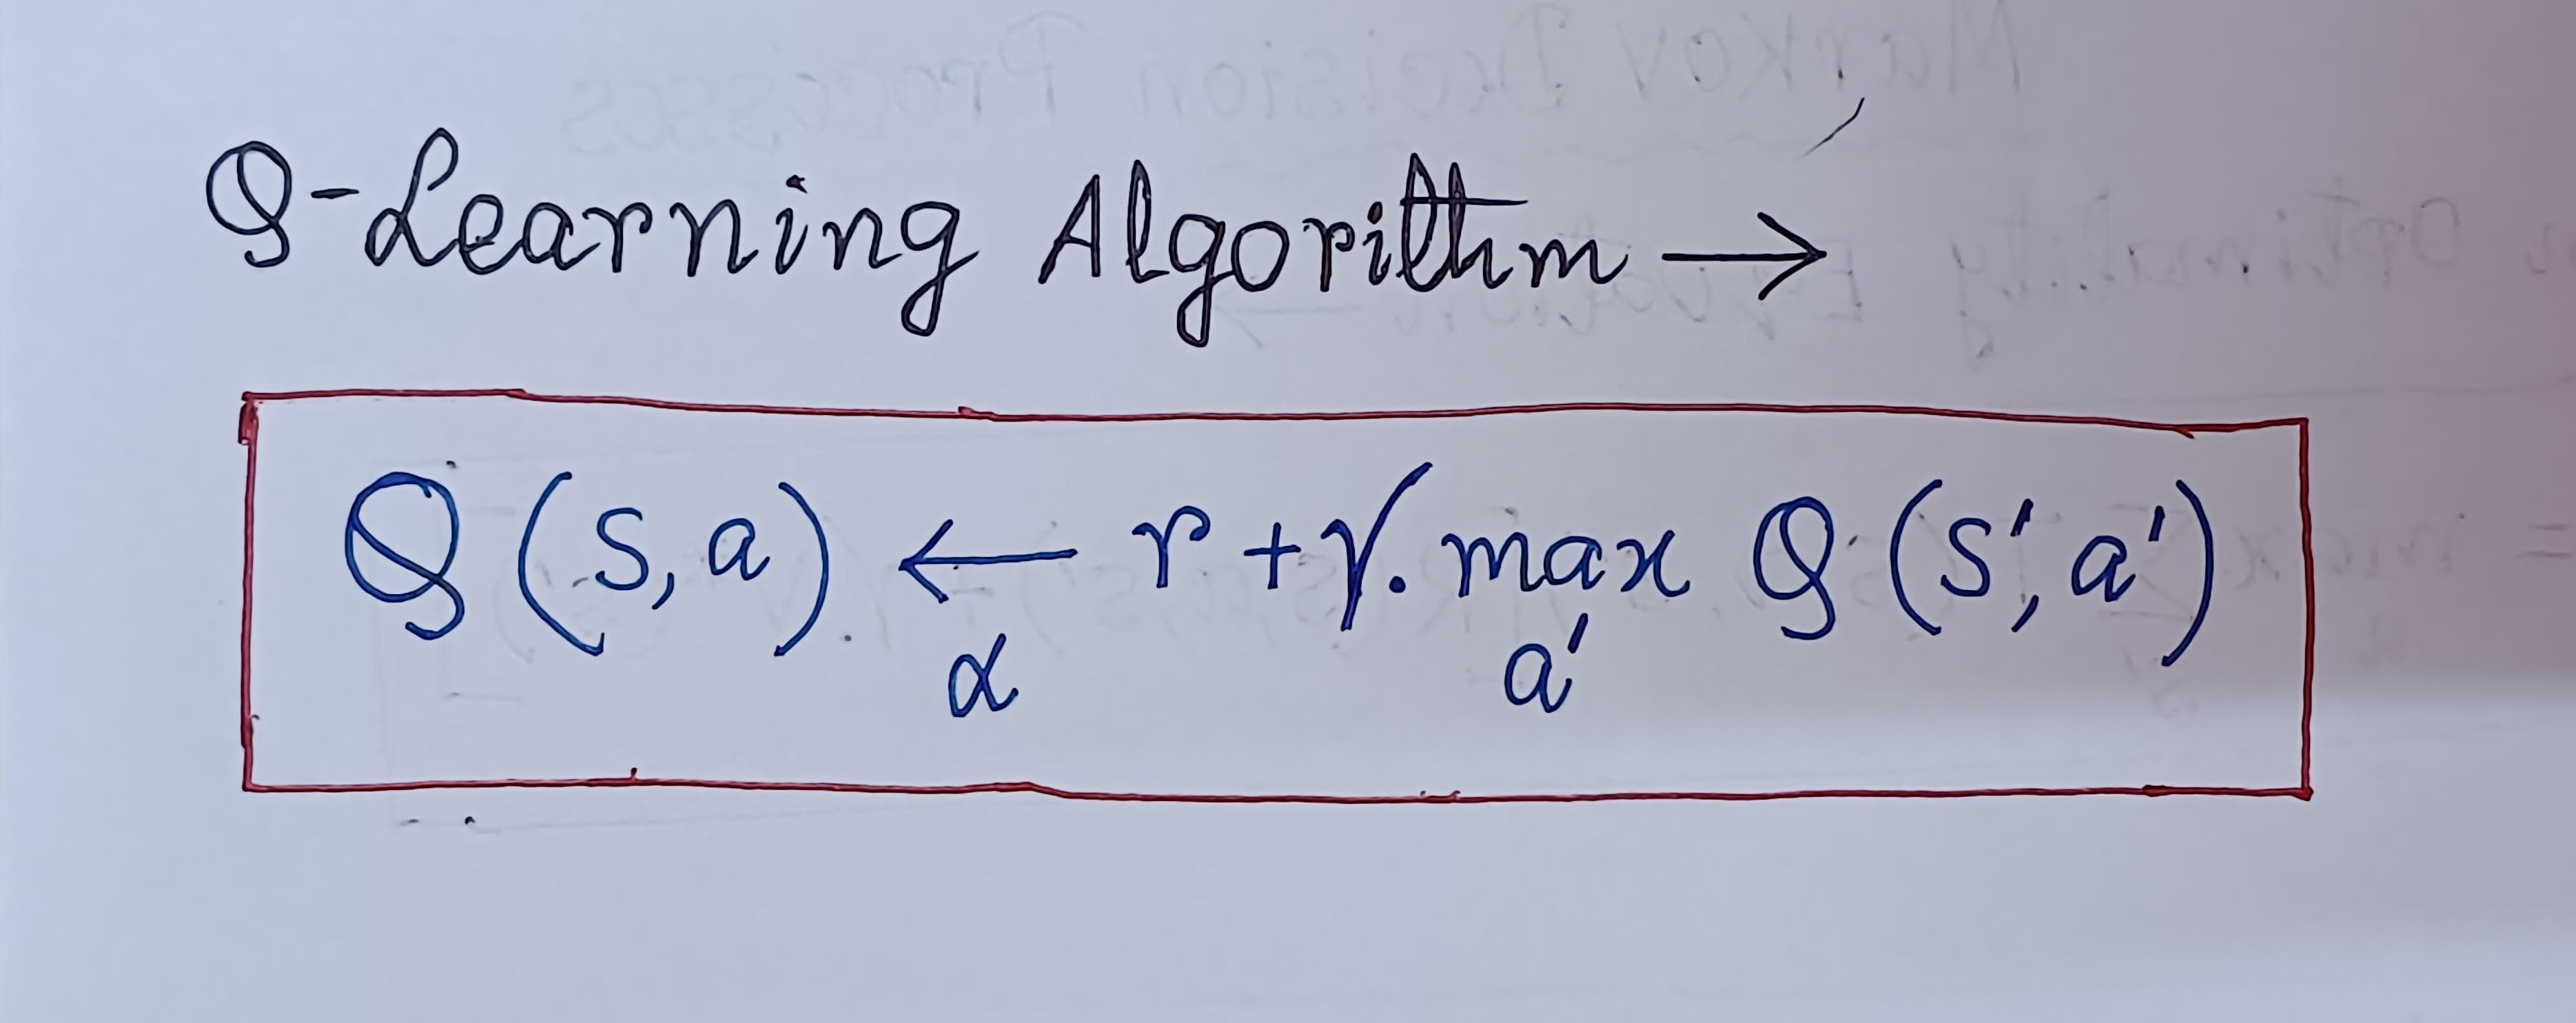

In [2]:
def step(state, action):
    
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p = probas)
    reward = rewards[state][action][next_state]
    
    return next_state, reward

In [3]:
import numpy as np

def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [4]:
alpha0 = 0.05         # Initial learning rate;
decay = 0.005         # Learning rate decay;
gamma = 0.90          # Discount factor;
state = 0             # Initial State;

In [5]:
for iteration in range(10_000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()     # Greedy policy at the next step;
    aplha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

NameError: name 'possible_actions' is not defined

### Deep Q-Learning;

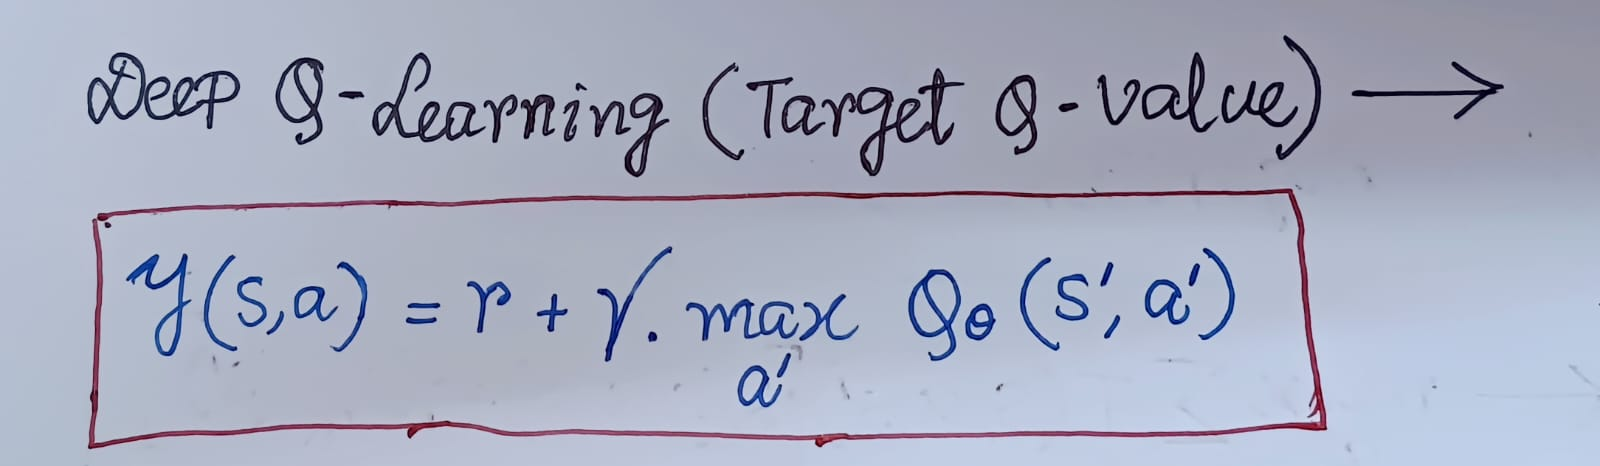

In [13]:
import tensorflow as tf

input_shape = [4]    # == env.observation_space.shape;
n_outputs = 2        # == env.action_space.n;

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='elu', input_shape = input_shape),
    tf.keras.layers.Dense(32, activation = 'elu'),
    tf.keras.layers.Dense(n_outputs)
])

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)   # Random action;
    else:
        Q_values = model.predict(state[np.newaxis], verbose = 0)[0]
        
        return Q_values.argmax()         # Optimal action according to the DQN

In [17]:
from collections import deque

In [19]:
replay_buffer = deque(maxlen = 2000)

In [21]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size = batch_size)
    batch = [replay_buffer[index] for index in indices]
    
    return [
        np.array([experience[field-index] for experience in batch])
        for field_index in range(6)
    ]             # [sates, actions, rewards, next_states, dones, truncateds]

In [23]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reaward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    
    return next_state, reward, done, truncated, info

In [27]:
!pip install tensorflow

In [33]:
import tensorflow as tf
import keras
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate = 1e-2)
loss_fn = keras.losses.mean_squared_error

In [35]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)          #Episode is not done or truncated
    
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [54]:
!pip install pygame

In [60]:
# Now training the model  is straightforward;

for episode in range(600):
    obs, info = env.reset()
    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, trucated, info = play_one_step(env, obs, epsilon)
        
        if done or truncated:
            break
            
    if episode > 50:
        training_step(batch_size)

AttributeError: module 'pygame' has no attribute 'env'

#### Fixed Q-value Targets;

In [43]:
import tensorflow as tf

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [45]:
next_Q_values = target.predict(next_states, verbose = 0)

NameError: name 'next_states' is not defined

In [47]:
if episode % 50 == 0:
    target.set_weights(model.get_weights())

#### Double DQN;

In [50]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose = 0)
    best_next_actions = next_Q_values.argmax(axis = 1)
    next_mask = tf.one_hot(best_next_actions, n_outputds).numpy()
    max_next_Q_values = (target.predict(next_states, verbose = 0) * next_mask).sum(axis=1)